In [1]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas
import math

# make this point to the file with the clean tweets
DATAFILE = "data_clean_stemmed_withoutRT.csv"
DATAFILE_ORIGINAL = "data_original_notStemmed_withoutRT.csv"

In [2]:
# read the csv
data = pandas.read_csv(DATAFILE, index_col=0)
data_original = pandas.read_csv(DATAFILE_ORIGINAL, index_col=0)

# NAs = data["is_retweet"].isna()
# rt_present = []
# for i in range(len(data)):
#     if NAs[i]:
#         rt_present.append('rt' in data["text"])

# # if no data is given, assume that 'rt' tells us
# # if a tweet is a retweet or not
# data["is_retweet"][data["is_retweet"].isna()] = rt_present

# # verify if all the retweets have the "rt" string
# all_have_rt = True
# # verity if all the tweets with "rt" are retweets
# all_are_retweets = True
# for i in range(len(data)):
#     if data["is_retweet"][i]:
#         all_have_rt &= "'rt'" in data["text"][i]
#     if "'rt'" in data["text"][i]:
#         all_are_retweets = all_are_retweets and data["is_retweet"][i]
# if all_have_rt:
#     print(f"All retweets have the 'rt' string")
# if all_are_retweets:
#     print(f"All 'rt' tweets are retweets")

In [3]:
# get all the tweets
# as of now, they are still strings, the string representation of the list
tweets = []
for tweet in data["text"]:
    tweets.append(eval(tweet))

# get the unique set of existing words and count those words
# check the most common ones
words = {}
total_words = 0
for tweet in tweets:
    for word in tweet:
        total_words += 1
        if word in words.keys():
            words[word] += 1
        else:
            words[word] = 1
print(f"We have {total_words} words, of which {len(words.keys())} are unique")
words_tuples = [(word, words[word]) for word in words.keys()]
words_tuples.sort(reverse=True, key=lambda t: t[1])

We have 53640 words, of which 4819 are unique


Text(0.5, 1.0, 'Most common tweet words')

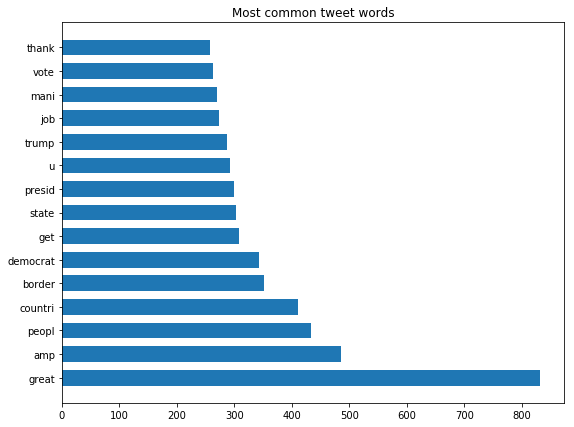

In [4]:
# plot a histogram of the N most common words
fig, ax = plt.subplots(figsize=(9,7))
N = 15
heights = [tup[1] for tup in words_tuples[:N]]
words = [tup[0] for tup in words_tuples[:N]]
indices = list(range(1, 3*N+1, 3))
bar_width = 2

ax.barh(indices, heights, bar_width)
ax.set_yticks(indices)
ax.set_yticklabels(words)
ax.set_title("Most common tweet words")

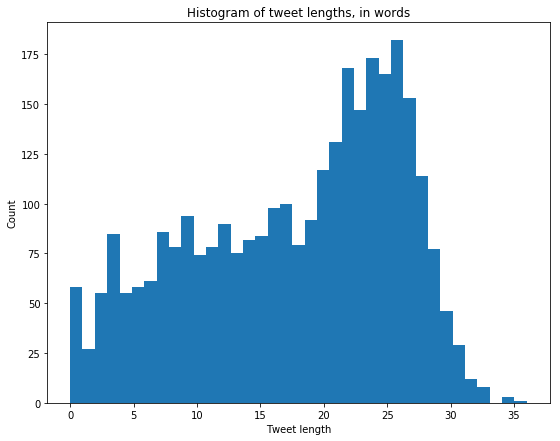

In [5]:
# plot a histogram of the number of words per tweet
lens = list(map(len, tweets))
maxsize = max(lens)

fig, ax = plt.subplots(figsize=(9,7))
ax.hist(lens, bins=maxsize+1);
ax.set_title("Histogram of tweet lengths, in words");
ax.set_xlabel("Tweet length");
ax.set_ylabel("Count");

There are 1744 words that only show up once


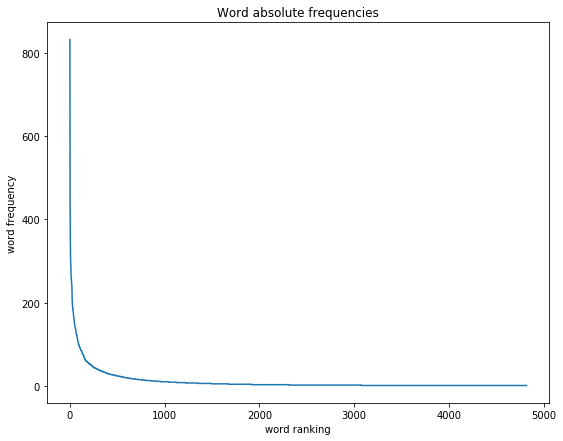

In [6]:
# check the curve of the frequencies
fig, ax = plt.subplots(figsize=(9,7))
freqs = [t[1] for t in words_tuples]
ax.plot(freqs)
ax.set_title("Word absolute frequencies")
ax.set_xlabel("word ranking")
ax.set_ylabel("word frequency")

first_one = freqs.index(1)
print(f"There are {len(freqs)-first_one} words that only show up once")

In [7]:
# check how many words make up some quantiles of the total number of words
quantiles = [0.5, 0.75, 0.9, 0.95]
# counts[i] is a pair (n, per) meaning that n words is the minimum number of
# words needed to make up for quantiles[i]% of all the words
counts = []
for q in quantiles:
    if counts:
        i = counts[-1][0]
        per = counts[-1][1]
    else:
        i = 0
        per = 0
    while per < q:
        i += 1
        per += words_tuples[i][1]/total_words
    counts.append((i, per))
for count in counts:
    print(f"{count[0]} words make up for {round(100*count[1],2)}% of all the words used")

248 words make up for 50.0% of all the words used
783 words make up for 75.01% of all the words used
1898 words make up for 90.01% of all the words used
3021 words make up for 95.0% of all the words used


['great', 'amp', 'peopl', 'countri', 'border', 'democrat', 'get', 'state', 'presid', 'u']


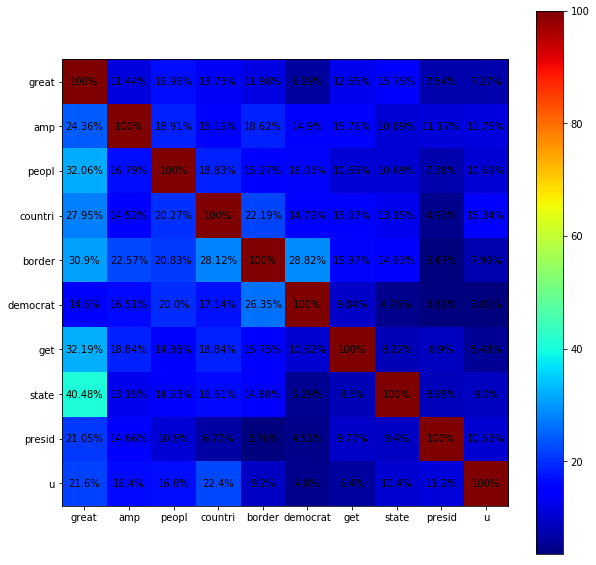

In [8]:
# take the N most common words and check how many times they show up together
N = 10
topN_words = [t[0] for t in words_tuples[:N]]
print(topN_words)
# matrix[i][j] has the percentage of tweets containing word i that also contained word j
matrix = [[0 for i in range(N)] for j in range(N)]
for j in range(N):
    base_word = topN_words[j]
    for tweet in tweets:
        if base_word in tweet:
            for i in range(j, N):
                scnd_word = topN_words[i]
                if scnd_word in tweet:
                    matrix[i][j] += 1
for j in range(N):
    for i in range(j):
        matrix[i][j] = matrix[j][i]
# at this step matrix[i][j] = matrix[j][i] only has, in (i,j), the number of times words i and j come up together
for i in range(N):
    for j in range(i+1, N):
        matrix[i][j] = round(matrix[i][j]/matrix[i][i]*100, 2)
    for j in range(i):
        matrix[i][j] = round(matrix[i][j]/matrix[i][i]*100, 2)
for i in range(N):
    matrix[i][i] = 100

# plot the matrix, code from
# https://stackoverflow.com/questions/5821125/how-to-plot-confusion-matrix-with-string-axis-rather-than-integer-in-python
fig = plt.figure(figsize=(10,10))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(matrix), cmap=plt.cm.jet, 
                interpolation='nearest')

width, height = N, N

for x in range(width):
    for y in range(height):
        ax.annotate(f"{matrix[x][y]}%", xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

cb = fig.colorbar(res)
plt.xticks(range(width), topN_words)
plt.yticks(range(height), topN_words)
None # prevent annoying extra output

In the above "confusion matrix" we can see, for example, that $32.39\%$ of all the tweets containing the word _people_ also contained the word _great_ (as we can confirm with the next snippet) but only $17.49\%$ of the tweets with the word _great_ contained the word _people_.

In [9]:
count = 0
hits = 0
for tweet in tweets:
    if "peopl" in tweet:
        count += 1
        if "great" in tweet:
            hits += 1
print(hits/count)

0.32061068702290074


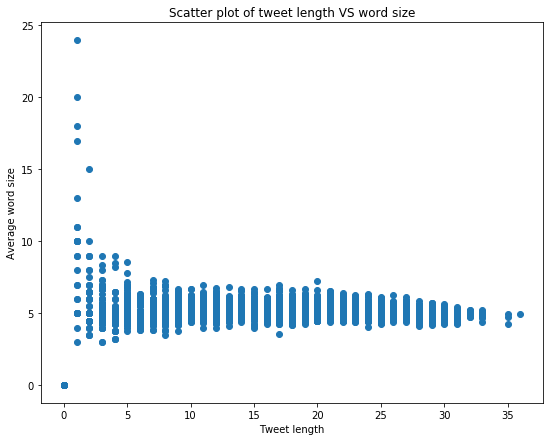

In [10]:
# check the relationship between amount of words and avg length of the words
lens = list(map(len, tweets))
avg_word_length = [sum([len(word) for word in tweets[i]])/lens[i] if lens[i] > 0 else 0 for i in range(len(lens))]

fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(lens, avg_word_length)
ax.set_title("Scatter plot of tweet length VS word size");
ax.set_xlabel("Tweet length");
ax.set_ylabel("Average word size");

In [11]:
# Note that some of the tweets with only 1 long word
# actually look like they were hashtags
for tweet in tweets:
    if len(tweet) == 1 and len(tweet[0]) > 10:
        print(tweet)

['armynavygam']
['hurricaneflor']
['pledgetoamericaswork']
['memorialday']
['peaceofficersmemorialday']
['usembassyjerusalem']
['nationaldayofpray']


In [12]:
# we also got a bunch of numbers in here
# and some single letter/2-letter words that don't look good
for word, count in words_tuples:
    if len(word) < 3:
        print(word)

u
go
us
th
nd
c
p
un
g
xi
h
ms
j
w
ad
r
mr
pm
ig
oh
rd
jr
ok
va
ye
gp
dr
el
ag
b
ga
k
e
v
de
la
st
n
bi
ii
bu
cd
z
lt
pa
l
iq
su
ap
al
da
ny
cb
nc
ex
vs
lo
eu
rv
hq
cr
ty
wh
co
vy
ca
q
x
op
ed
en
aw
vp
ol
vi
sc
fe
rx
yr
az
md
nh
lc
ac
fl
uk
jw
dh


In [13]:
# turn each tweet into a vector with N coordinates
# also, tag each tweet with a unique ID
# coordinate i of tweeter n will say how many times the top word i appeared
N = 50
topN_words = [t[0] for t in words_tuples[:N]]
vector_tweets = []
newID = 0
for tweet in tweets:
    counts = [tweet.count(word) for word in topN_words]
    # use numpy arrays so that later calculations are easier
    vector_tweets.append((newID, np.array(counts, dtype=int)))
    newID += 1

In [14]:
print(vector_tweets[:3])
print(vector_tweets[-3:])

[(0, array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0])), (1, array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0])), (2, array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0]))]
[(3032, array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0])), (3033, array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1])), (3034, array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 

In [15]:
# def tweet_distance(v1, v2):
#     return np.linalg.norm(v1-v2)

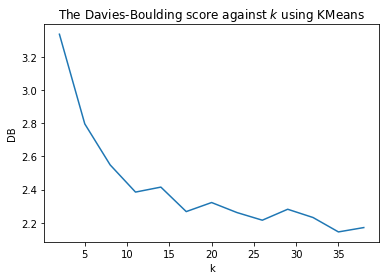

In [16]:
# Determine the Davies-Boulding Score for different values of K
K = range(2,40,3)
DB = np.zeros_like(K).astype(float)
i = 0

mat = np.array([t[1] for t in vector_tweets])
for k in K:
    kmeans = KMeans(n_clusters = k, random_state=73).fit(mat)
    with np.errstate(divide='ignore'):
        DB[i] = davies_bouldin_score(mat, kmeans.labels_)
    i += 1

plt.plot(K,DB)
plt.xlabel('k')
plt.ylabel('DB')
plt.title(r'The Davies-Boulding score against $k$ using KMeans')
plt.show()

For small values of the DB score the algorithm performs best. For large $k$ the DB score decreases as expected. We want to take $k$ such that $k$ is small but gives a low score for DB. We will take $k = 25$.

In [17]:
# Best small k according DB score

k = 25

# use scikit to perform KMeans
kmeans = KMeans(n_clusters = k, random_state=73).fit(mat)
sk_clusters = [[] for i in range(max(kmeans.labels_+1))]
for idx, lbl in enumerate(kmeans.labels_):
    sk_clusters[lbl].append(idx)
    
DB = davies_bouldin_score(mat, kmeans.labels_)

    
print(list(map(len, sk_clusters)))

[51, 756, 198, 83, 106, 158, 72, 77, 128, 86, 30, 73, 97, 101, 44, 97, 103, 97, 152, 93, 12, 180, 122, 56, 63]


C:\Users\Nerine.USMAN2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


In [18]:
# instead of using my terrible implementation, use scikit

kmeans = KMeans(n_clusters = 20, random_state=73).fit(mat)
sk_clusters = [[] for i in range(max(kmeans.labels_+1))]
for idx, lbl in enumerate(kmeans.labels_):
    sk_clusters[lbl].append(idx)
    
print(list(map(len, sk_clusters)))
# print(sk_clusters)

random.seed(52345234)
# take some random tweets from every cluster
for cluster in sk_clusters:
    some_tweet_idx = random.sample(cluster, 5)
    for idx in some_tweet_idx:
        print(idx)
        print(data_original["text"][idx].replace("', '", " "))
    print("-"*40)
    
# does the last cluster only contain retweets?
# print(all(map(lambda i: "'rt'" in data["text"][i], sk_clusters[-1])))
# it does!



[140, 82, 196, 160, 78, 65, 278, 155, 149, 93, 125, 118, 63, 910, 148, 22, 75, 78, 69, 31]
1339
Thank you for the kind words Omarosa! https://t.co/PMmNG6iIsi
736
Thank you to the Cherokee Nation for revealing that Elizabeth Warren, sometimes referred to as Pocahontas, is a complete and total Fraud!
860
Thank you Tennessee - I love you! https://t.co/1swpoY7F5x
1272
Thank you West Virginia. I love you! https://t.co/K1OQ98wOh4
1888
I was thrilled to be back in Minnesota for a roundtable with hardworking American Patriots. Thank you! https://t.co/suoRN02zMq
----------------------------------------
1519
MAKING AMERICA GREAT AGAIN! https://t.co/OnMGXvldVT
2961
AMERICA will once again be a NATION that thinks big, dreams bigger, and always reaches for the stars. YOU are the ones who will shape America’s destiny. YOU are the ones who will restore our prosperity. And YOU are the ones who are MAKING AMERICA GREAT AGAIN! #MAGA https://t.co/f2abNK47II
1322
Wow! Big pushback on Governor Andrew Cuomo

We have 1469 words, of which 747 are unique
We have 1428 words, of which 563 are unique
We have 4103 words, of which 1447 are unique
We have 3074 words, of which 1158 are unique
We have 1799 words, of which 471 are unique
We have 1106 words, of which 533 are unique
We have 4522 words, of which 1530 are unique
We have 3401 words, of which 1035 are unique
We have 2897 words, of which 1169 are unique
We have 2599 words, of which 995 are unique
We have 2322 words, of which 954 are unique
We have 2272 words, of which 1003 are unique
We have 1557 words, of which 592 are unique
We have 12061 words, of which 2745 are unique
We have 2918 words, of which 983 are unique
We have 557 words, of which 252 are unique
We have 1658 words, of which 551 are unique
We have 1715 words, of which 612 are unique
We have 1506 words, of which 572 are unique
We have 676 words, of which 341 are unique


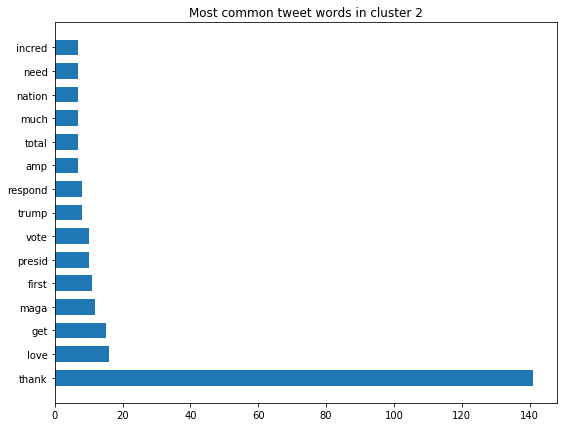

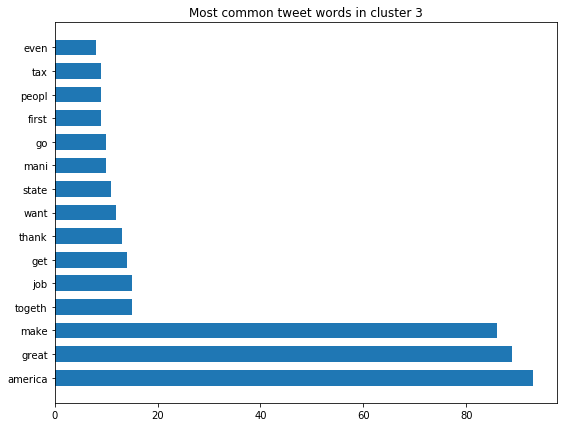

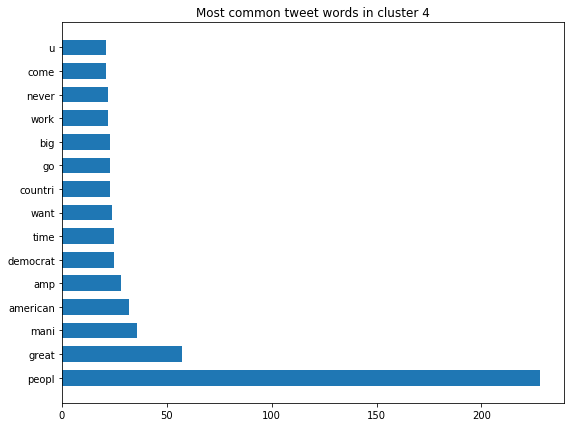

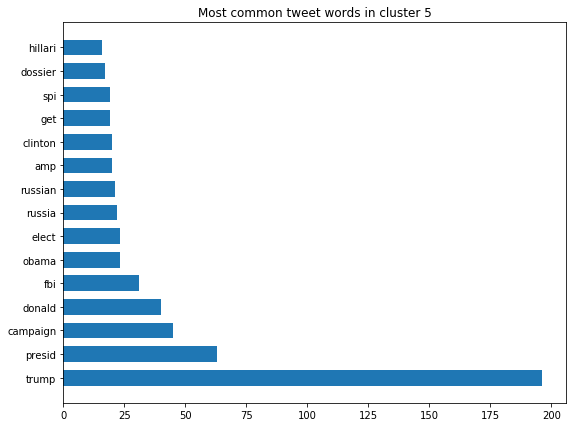

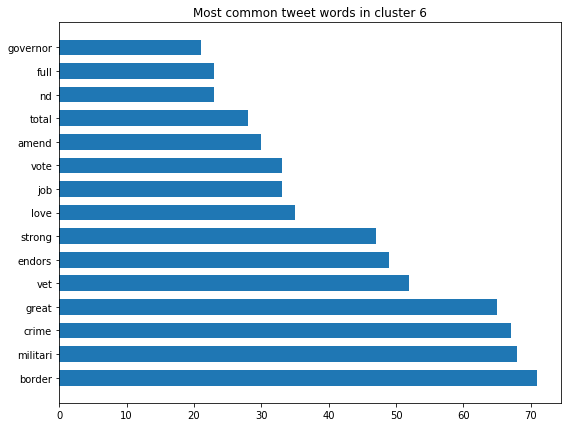

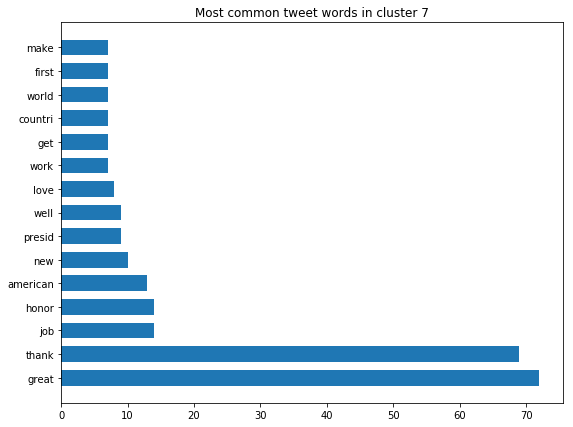

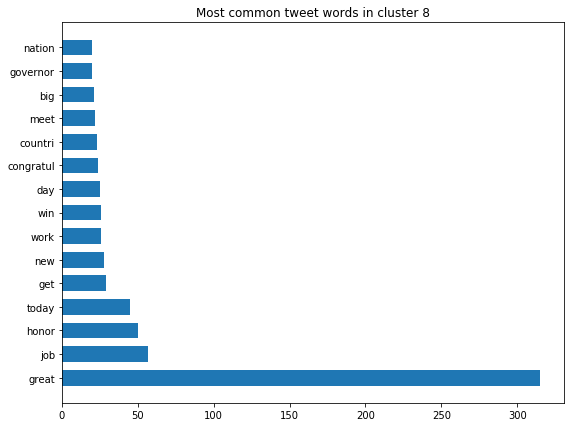

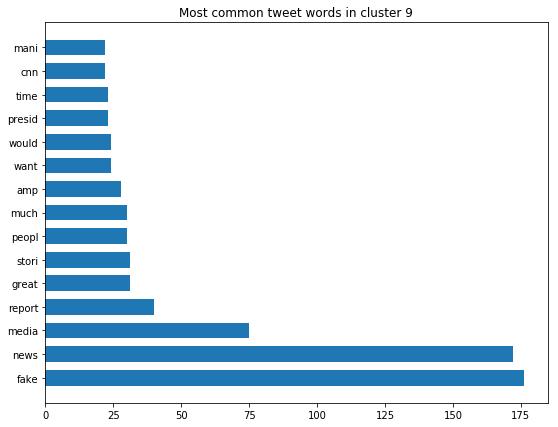

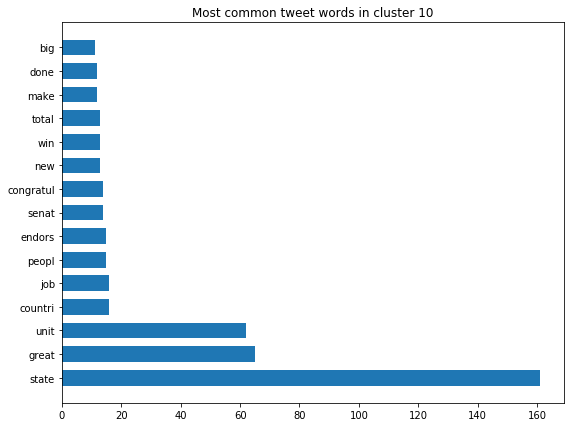

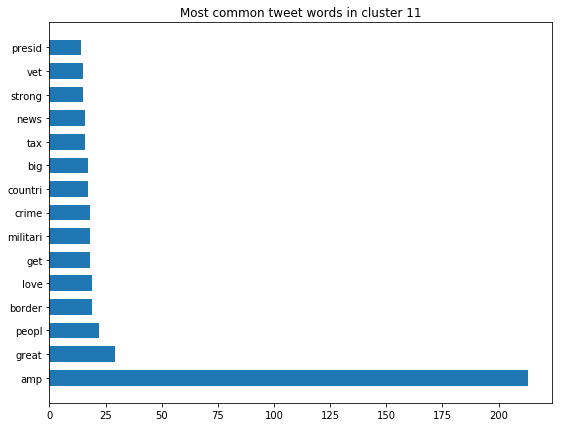

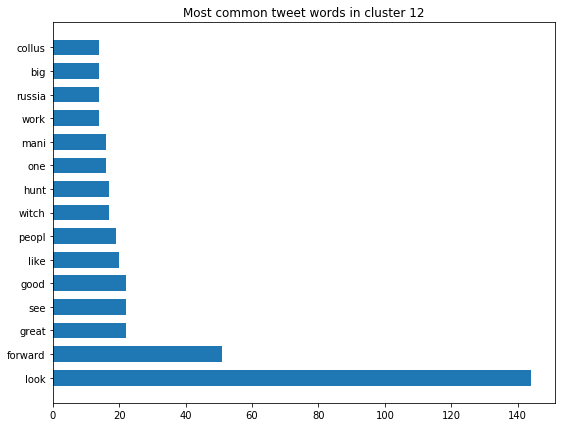

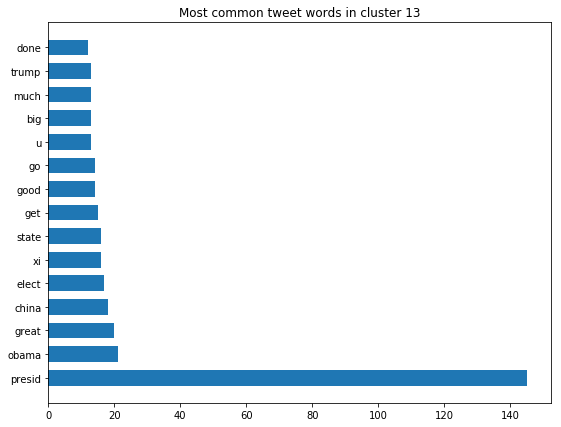

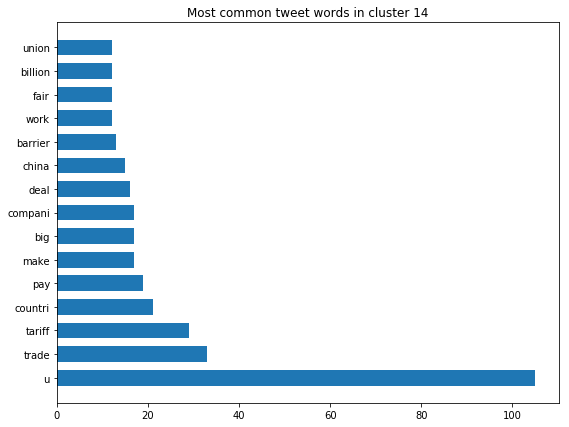

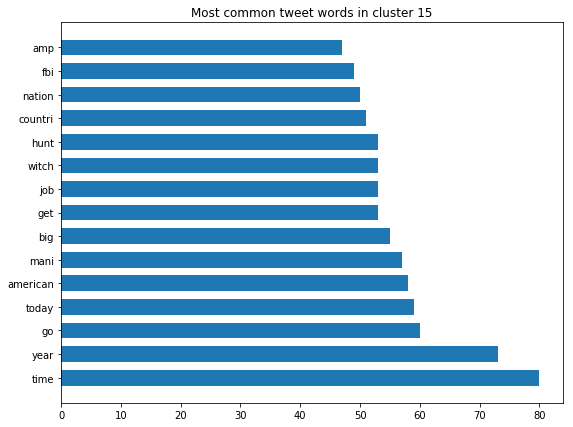

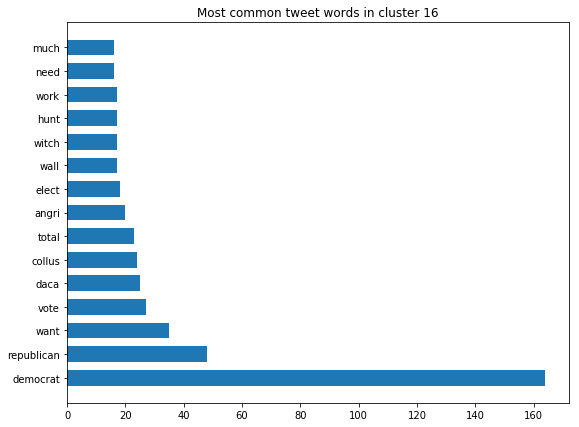

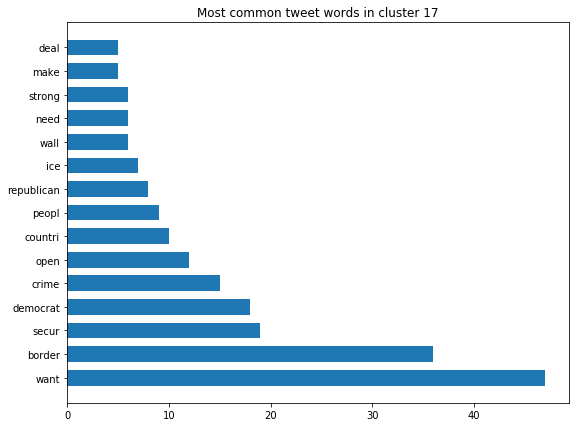

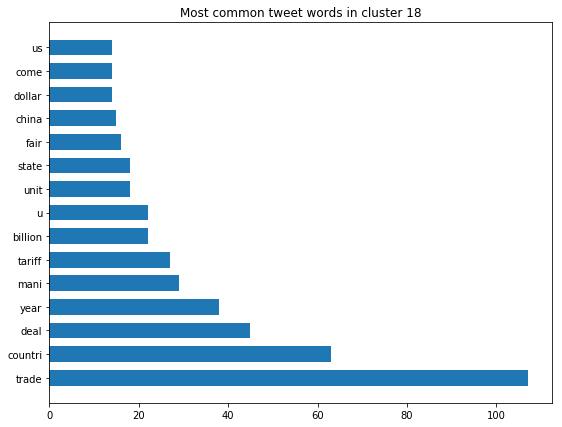

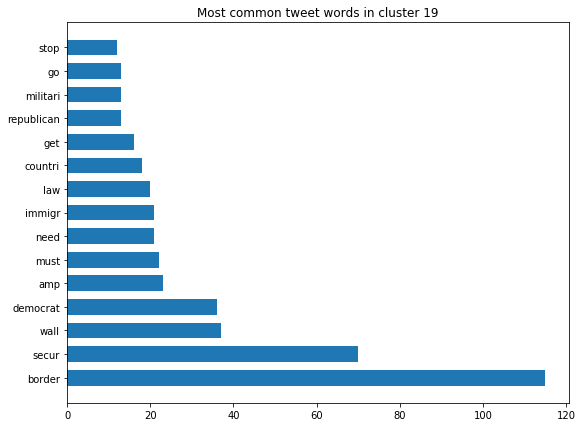

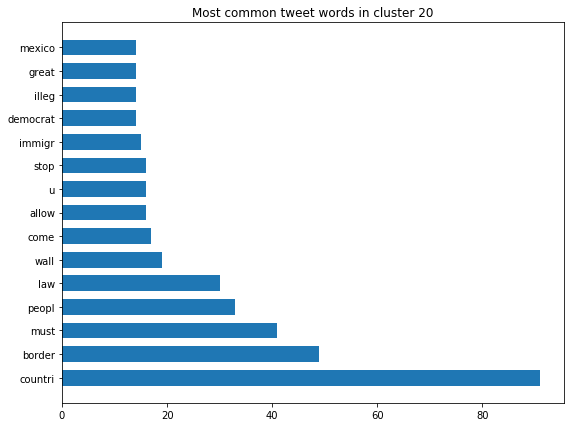

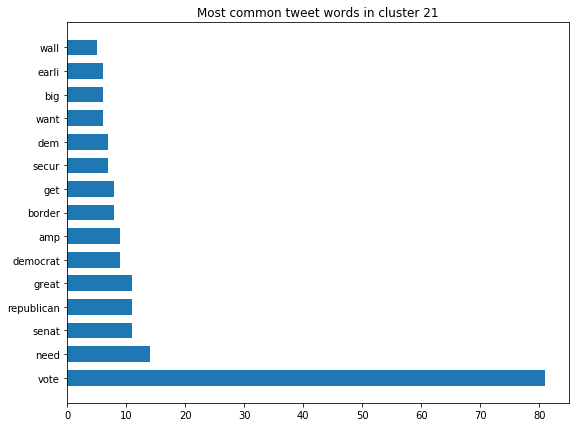

In [19]:
## Visualize different clusters

nr_cluster = 1
for cluster in sk_clusters:
    nr_cluster += 1
    tweets = []
    for tweet in data["text"][cluster]:
        tweets.append(eval(tweet))

    # get the unique set of existing words and count those words
    # check the most common ones
    words = {}
    total_words = 0
    for tweet in tweets:
        for word in tweet:
            total_words += 1
            if word in words.keys():
                words[word] += 1
            else:
                words[word] = 1
    print(f"We have {total_words} words, of which {len(words.keys())} are unique")
    words_tuples = [(word, words[word]) for word in words.keys()]
    words_tuples.sort(reverse=True, key=lambda t: t[1])
    # plot a histogram of the N most common words
    fig, ax = plt.subplots(figsize=(9,7))
    N = 15
    heights = [tup[1] for tup in words_tuples[:N]]
    words = [tup[0] for tup in words_tuples[:N]]
    indices = list(range(1, 3*N+1, 3))
    bar_width = 2

    ax.barh(indices, heights, bar_width)
    ax.set_yticks(indices)
    ax.set_yticklabels(words)
    ax.set_title("Most common tweet words in cluster "+str(nr_cluster))

